In [1]:
import muon as mu
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys

# Import Custom scripts
sys.path.append("./scripts/")
from scripts.sc_rna_helper.sc_diff_gex import PseudoBulk

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mdata = mu.read_h5mu("../data/annotations/121c_consensus_celltype.h5mu")
print(mdata["gex"].n_vars, "total genes")
print(mdata["gex"].n_obs, "total cells")

4000 total genes
11246 total cells


In [3]:
rna_adata = mdata["gex"].copy()

### Drop Genes that aren't biologically relevant

In [4]:
to_drop = ["XIST", "TSIX", "RPS26"] # These are X-chromosome genes
rna_adata = rna_adata[:, ~rna_adata.var_names.isin(to_drop)]

In [6]:
cell_type_dict = {
    "T cells": ['gdT', 'CD4 Memory', 'CD8 Memory', 'CD4 Naive', 'CD8 Proliferating', 'CD8 Naive', 'CD4 Proliferating', 'Treg'],
    "Monocytes": ['CD14 Mono', 'CD16 Mono'],
    "NK cells": ['NK', 'NK_CD56bright', 'NK Proliferating'],
    "Dendritic cells": ['cDC2', 'cDC1', 'pDC'],
    "B cells": ['B intermediate', 'Plasmablast'],
}


def l1_to_l2_naming(cell_type_dict, l1_name):

    for parent, children in cell_type_dict.items():
        if l1_name in children:
            return parent
    return l1_name

rna_adata.obs["consensus_l2_celltype"] = rna_adata.obs["consensus_celltype"].map(lambda x: l1_to_l2_naming(cell_type_dict, x))

/var/folders/xz/k3tl_sxx7r7_7sftwwwf_v1m0000gq/T/ipykernel_96684/4084378183.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_adata.obs["consensus_l2_celltype"] = rna_adata.obs["consensus_celltype"].map(lambda x: l1_to_l2_naming(cell_type_dict, x))


## Generate Pseudobulks

* For each patient we create 1 pseudobulk sample per cell type by aggregating the cell from each subpopulation and taking the mean gene expression within that subpopulation.
* If the data you are working with does not have replicates, it could be beneficial to create multiple (e.g. 2-3) pseudobulks per patient to account for patient variability. 

### Quick View of Cell Type Distribution
- Red highlights indicate cells below min cell cut-off you provide.

In [8]:
# Change Me
min_num_cells = 10

def color_below_threshold(val, threshold, def_color="black", highlight_color="red"):
    color = highlight_color if val < threshold else def_color
    return f'color: {color}'

df = rna_adata.obs.groupby(["ID", "day_label", "consensus_l2_celltype"], as_index=False).size()
df.sort_values(["ID", "day_label"], ascending=False, inplace=True)

df = df.pivot(columns=["ID", "day_label"], values="size", index="consensus_l2_celltype").T
df.columns.name = None
df.index.names = [None, None]

df.style.applymap(lambda x: color_below_threshold(x, min_num_cells))

In [9]:
rna_adata.obs["gvhd_lbl"] = rna_adata.obs["aghvd"].map({"yes": "GVHD", "no": "CONT"}).astype(str)  + " : " + rna_adata.obs["day_label"].astype(str)

In [12]:
rna_adata.obs

,Cell_Type_Experimental,Sample_Tag,Sample_Name,SampleTag01_hs_Read_Count,SampleTag02_hs_Read_Count,SampleTag03_hs_Read_Count,SampleTag04_hs_Read_Count,SampleTag05_hs_Read_Count,SampleTag06_hs_Read_Count,SampleTag07_hs_Read_Count,...,ct_high_predicted_labels,ct_high_over_clustering,ct_high_majority_voting,ct_high_conf_score,abt_label,is_gdT,consensus_celltype,day_label,consensus_l2_celltype,gvhd_lbl
57,T_gamma_delta,SampleTag03_hs,SampleTag03_hs,128,27,7286,39,17,18,17,...,Mono-mac,12,Mono-mac,0.999995,nan,gdT,gdT,D21/42,T cells,GVHD : D21/42
408,Monocyte_classical,SampleTag10_hs,SampleTag10_hs,13,103,24,60,25,20,42,...,Monocytes,4,Monocytes,0.999070,nan,NaN,CD14 Mono,graft,Monocytes,CONT : graft
461,T_CD4_memory,SampleTag12_hs,SampleTag12_hs,6,1,0,44,4,8,23,...,Mono-mac,29,T cells,1.000000,CD4 TCM,NaN,CD4 Memory,D90/120,T cells,CONT : D90/120
467,Monocyte_classical,SampleTag04_hs,SampleTag04_hs,10,38,55,24086,46,38,46,...,Monocytes,13,Monocytes,0.999996,nan,NaN,CD14 Mono,D90/120,Monocytes,GVHD : D90/120
860,Natural_killer,SampleTag04_hs,SampleTag04_hs,11,36,17,12456,1,37,66,...,ILC,46,ILC,1.000000,nan,NaN,NK,D90/120,NK cells,GVHD : D90/120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14042536,Monocyte_classical,SampleTag03_hs,SampleTag03_hs,2,44,3548,8,20,88,29,...,Monocytes,51,Monocytes,1.000000,nan,NaN,CD14 Mono,D21/42,Monocytes,GVHD : D21/42
14042585,T_CD8_memory,SampleTag01_hs,SampleTag01_hs,2309,9,11,16,5,20,9,...,T cells,0,T cells,1.000000,CD8 Naive,NaN,CD8 Naive,donor,T cells,GVHD : donor
14044069,Dendritic,SampleTag02_hs,SampleTag02_hs,12,8038,21,19,47,29,12,...,Macrophages,74,Mono-mac,0.512632,nan,NaN,HSPC,graft,HSPC,GVHD : graft
14044456,Monocyte_classical,SampleTag10_hs,SampleTag10_hs,30,132,49,72,33,51,63,...,Monocytes,4,Monocytes,0.999942,nan,NaN,CD14 Mono,graft,Monocytes,CONT : graft


In [26]:
obs_cols = ["day_label"] # To add other variables from .obs
# obs_cols = None

pseudo = PseudoBulk(rna_adata, sample_key="gvhd_lbl", cell_id_key="consensus_l2_celltype")
pseudo.set_min_number_cells(min_num_cells)
cell_type = "T cells"

# # Run this if don't need pseudo replicates
# adata_pb = pseudo.generate_pseudo_bulk(condition_key="aghvd", cell_type=cell_type, raw_data_layer="raw", cols_to_keep=obs_cols)

# Run this if wanting to generate pseudo replicates
pseudo.set_replicates_per_sample(5)
adata_pb = pseudo.generate_pseudo_dbulk_psuedo_rep(condition_key="aghvd", cell_type=cell_type , raw_data_layer="raw", cols_to_keep=obs_cols)

adata_pb.obs.head(10)

,day_label,aghvd,sample,replicate,cell_type,num_cells
GVHD : D21/42_1,D21/42,yes,GVHD : D21/42,1,T cells,307
GVHD : D21/42_2,D21/42,yes,GVHD : D21/42,2,T cells,307
GVHD : D21/42_3,D21/42,yes,GVHD : D21/42,3,T cells,307
GVHD : D21/42_4,D21/42,yes,GVHD : D21/42,4,T cells,306
GVHD : D21/42_5,D21/42,yes,GVHD : D21/42,5,T cells,306
CONT : D90/120_1,D90/120,no,CONT : D90/120,1,T cells,114
CONT : D90/120_2,D90/120,no,CONT : D90/120,2,T cells,114
CONT : D90/120_3,D90/120,no,CONT : D90/120,3,T cells,114
CONT : D90/120_4,D90/120,no,CONT : D90/120,4,T cells,114
CONT : D90/120_5,D90/120,no,CONT : D90/120,5,T cells,113


In [29]:
pseudo.samples_rm

{'CONT : graft'}

# Run DeSeq2

In [30]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [31]:
grouped_dict = {key[0]:list(data.index) for key, data in adata_pb.obs.groupby(["day_label"])}
grouped_dict.keys()

dict_keys(['D21/42', 'D90/120', 'donor', 'graft'])

In [32]:
timepoint = "D21/42"

# Create Counts Matrix for Deseq2
sub_pb_adata = adata_pb[grouped_dict[timepoint]].copy()

#### Remove Replicates with less then number of cells
rows = sub_pb_adata.obs["num_cells"] >= min_num_cells

counts_mtx = pd.DataFrame(sub_pb_adata[rows].X, columns=sub_pb_adata.var_names)
dds = DeseqDataSet(counts=counts_mtx, metadata=sub_pb_adata[rows].obs, design_factors="aghvd")

In [33]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.43 seconds.

Fitting dispersion trend curve...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 0.27 seconds.

Fitting LFCs...
... done in 0.78 seconds.

Refitting 0 outliers.



/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


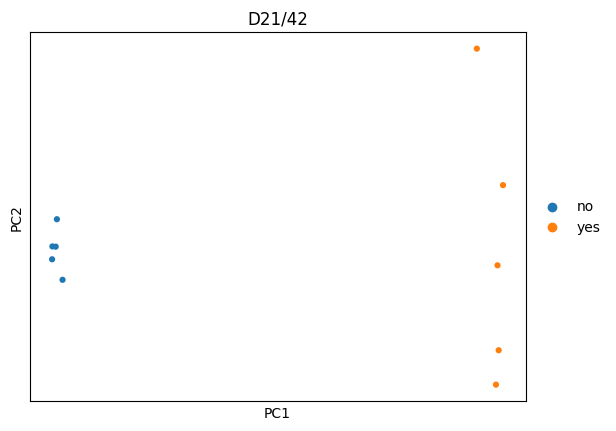

In [34]:
sc.tl.pca(dds)
sc.pl.pca(dds, s=80, color=["aghvd"], title=timepoint.capitalize())

In [35]:
stat_res = DeseqStats(dds, n_cpus=8, contrast=("aghvd", "yes", "no"))
stat_res.summary()
de = stat_res.results_df.reset_index(names="genes")

Running Wald tests...


Log2 fold change & Wald test p-value: aghvd yes vs no


... done in 0.40 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,88.811525,-3.508938,0.231001,-15.190122,4.111555e-52,2.054235e-49
AAK1,96.006690,-0.354947,0.189958,-1.868558,6.168433e-02,1.242077e-01
AATF,35.243401,0.313483,0.230670,1.359011,1.741430e-01,2.823731e-01
ABCA1,8.448503,-0.383057,0.425969,-0.899261,3.685134e-01,4.961092e-01
ABCC1,60.324147,-0.049872,0.168072,-0.296727,7.666749e-01,8.427655e-01
...,...,...,...,...,...,...
ZSWIM6,43.784710,-0.905145,0.186524,-4.852706,1.217883e-06,1.063556e-05
ZXDC,29.366251,-0.085331,0.241839,-0.352842,7.242072e-01,8.101473e-01
ZYX,39.294792,0.834381,0.236733,3.524570,4.241709e-04,1.930992e-03
ZZEF1,42.216640,-0.625418,0.190763,-3.278507,1.043578e-03,4.179539e-03


In [36]:
from bioinfokit import visuz

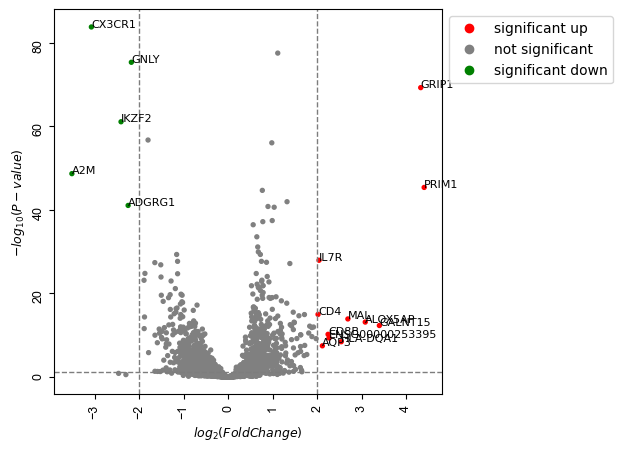

In [41]:
log_fc = (2, 2) # (Downregulated, Upregulated) fold change
pvals = (0.05, 0.05) # (Upregulated, Downregulated) pvals

visuz.GeneExpression.volcano(df=de.dropna(),
                             lfc="log2FoldChange", 
                             pv="padj", 
                             show=True, 
                             plotlegend=True, 
                             legendpos='upper right',
                             legendanchor=(1.46,1),
                             sign_line=True,
                             lfc_thr=log_fc,
                             pv_thr=pvals,
                             geneid="genes",
                             genenames="deg",
                             color=('red', 'grey', 'green'),
                            )

In [42]:
sig_fc_rows = np.abs(de["log2FoldChange"]) >= log_fc[0]
sig_pval_rows = de["padj"] < pvals[0]
de_sig = de[sig_fc_rows & sig_pval_rows]

# Plot Heatmap of Significant Genes

In [43]:
import seaborn as sns

In [44]:
adata_pb.layers["raw"] = adata_pb.X.copy()
sc.pp.log1p(adata_pb)

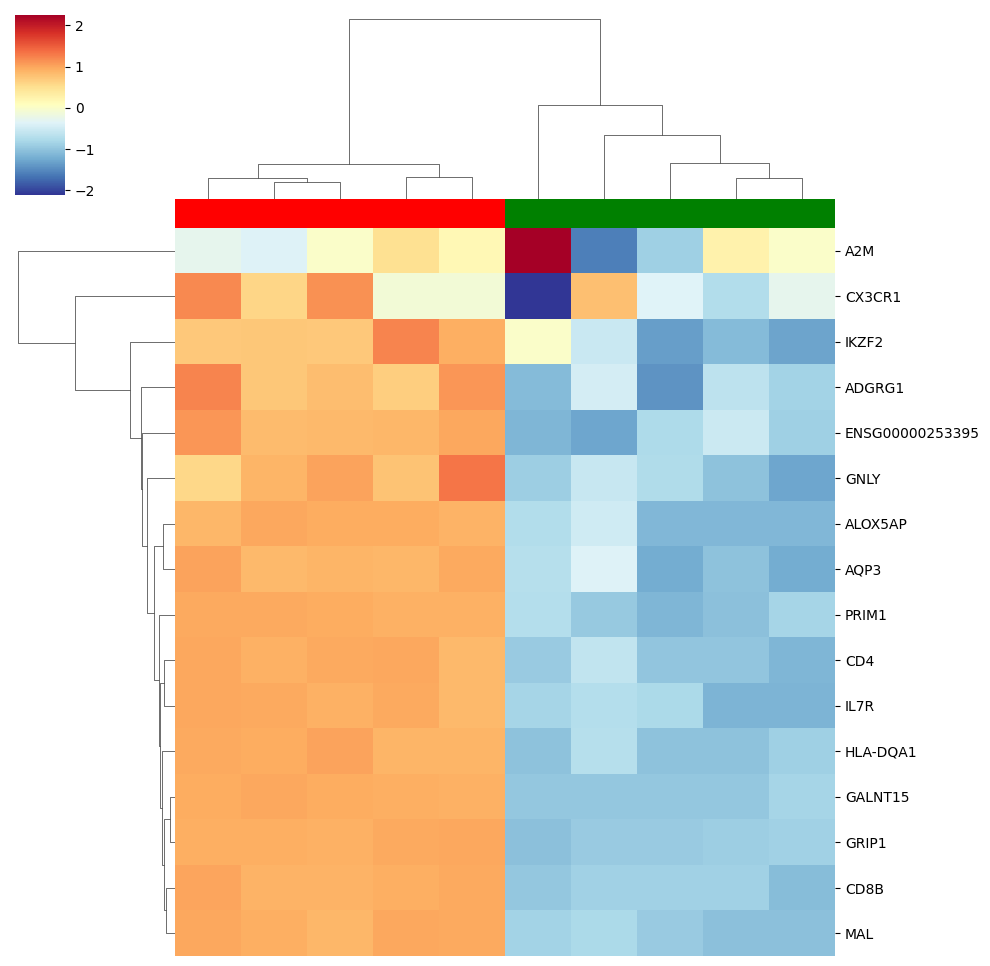

In [45]:
tp_rows = adata_pb.obs["day_label"] == timepoint
sig_genes = list(de_sig["genes"])

sig_adata =  adata_pb[tp_rows, sig_genes].copy()

df = pd.DataFrame(
    sig_adata.X,
    columns=sig_adata.var_names
)
colors = sig_adata[:, sig_genes].obs["aghvd"].map({"yes": "red", "no": "green"}).values
ax = sns.clustermap(df.T, z_score=0, cmap="RdYlBu_r", col_colors=colors, figsize=(10, 10), yticklabels=True)
ax_heat = ax.ax_heatmap
ax_heat.set_xticks([]);

# Plot Dotplots

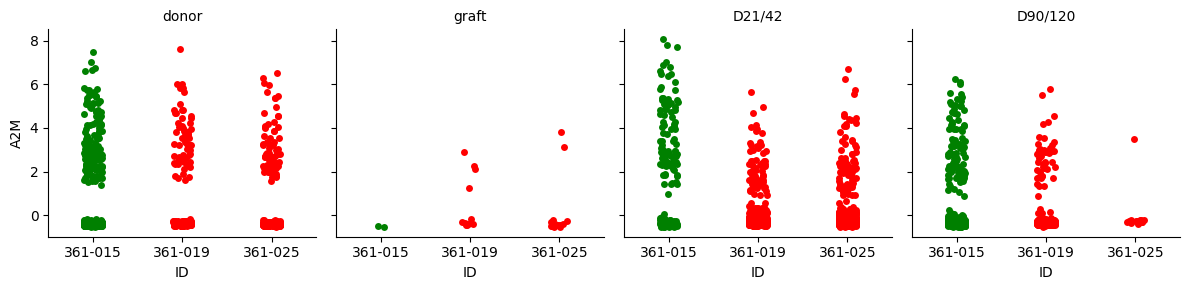

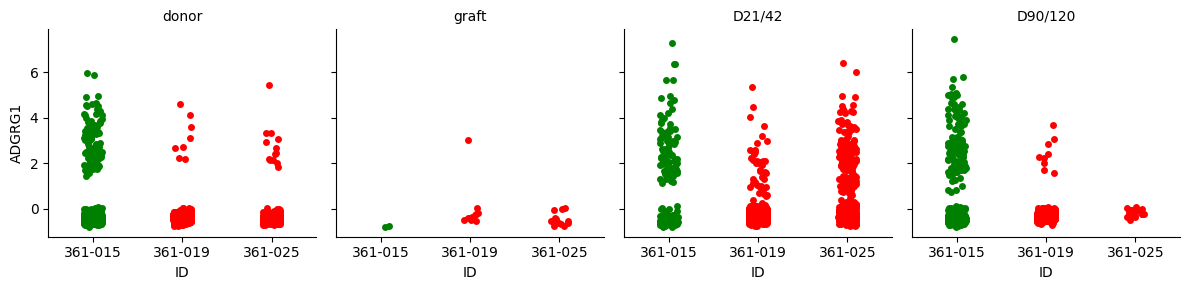

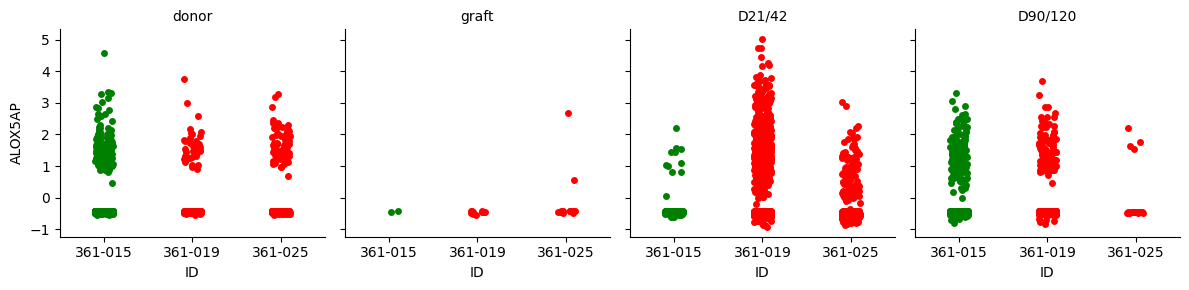

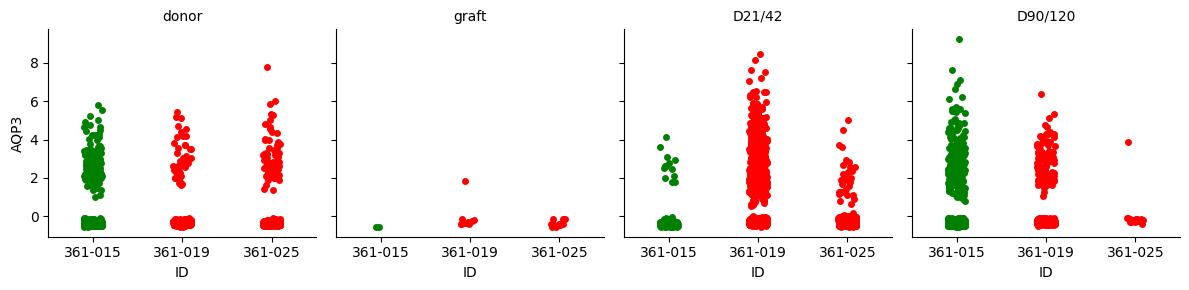

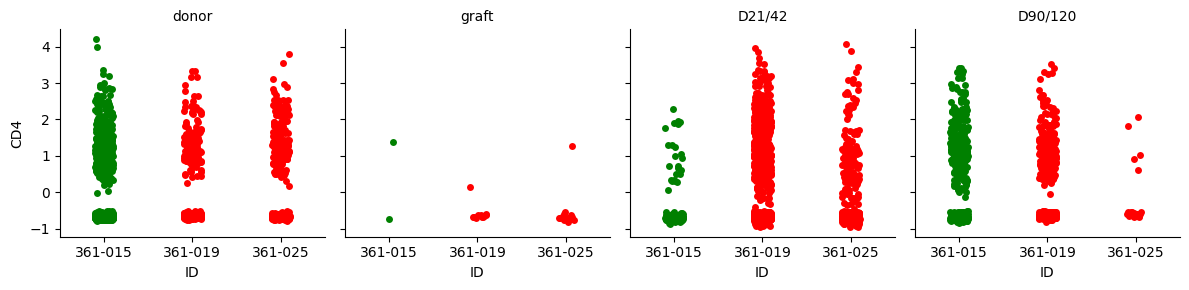

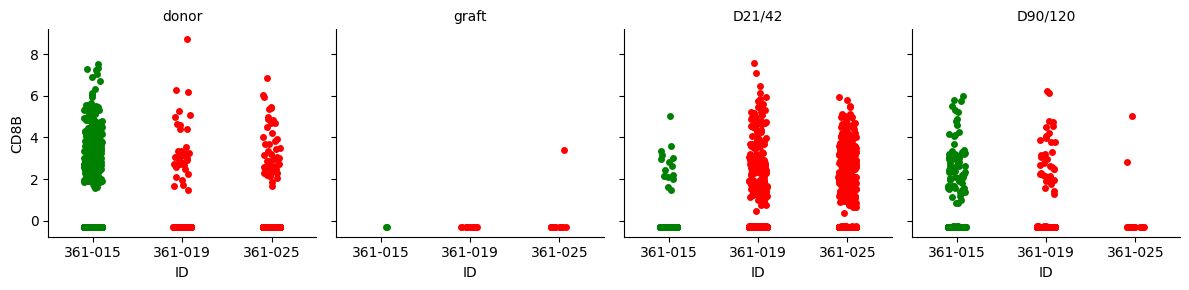

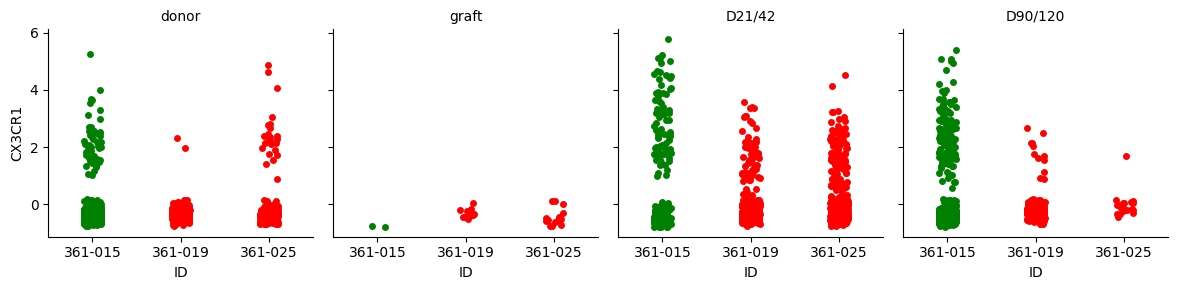

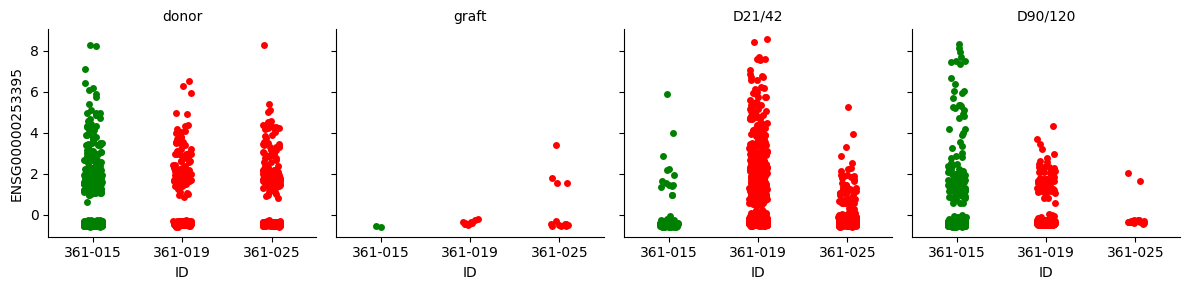

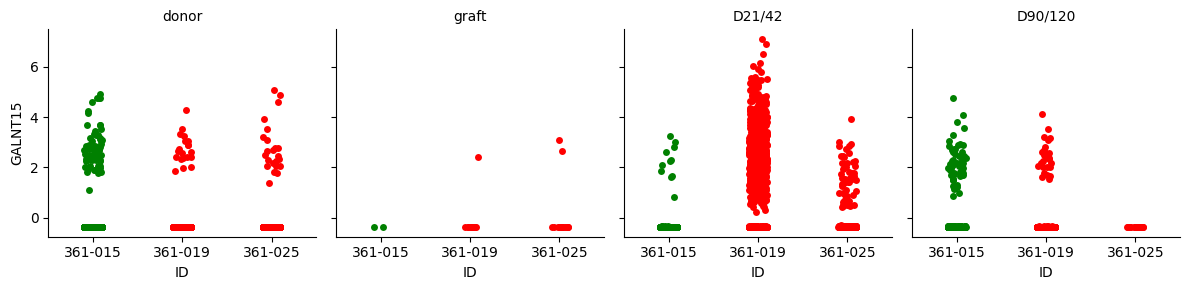

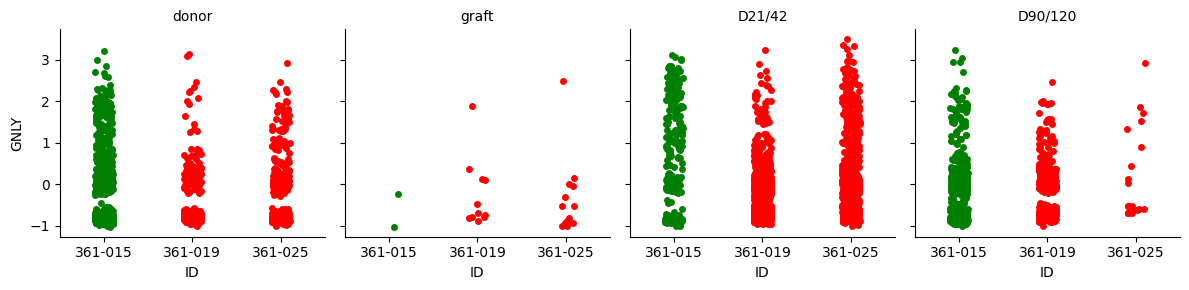

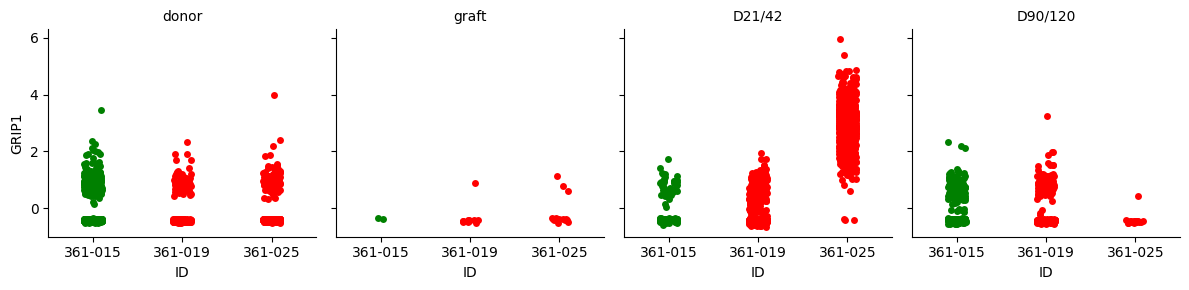

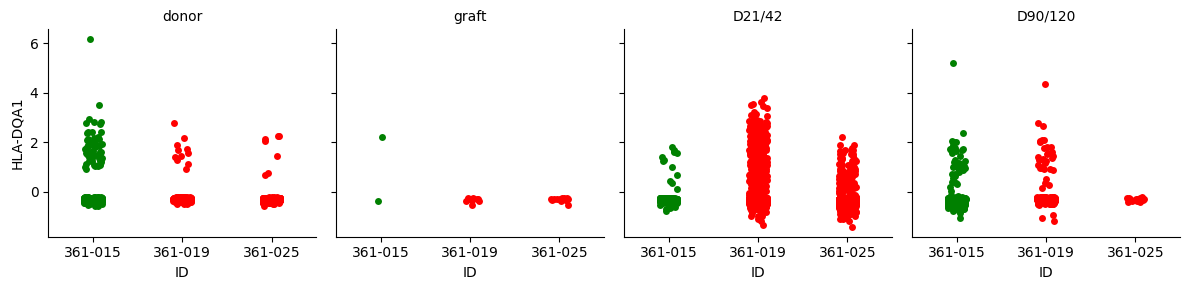

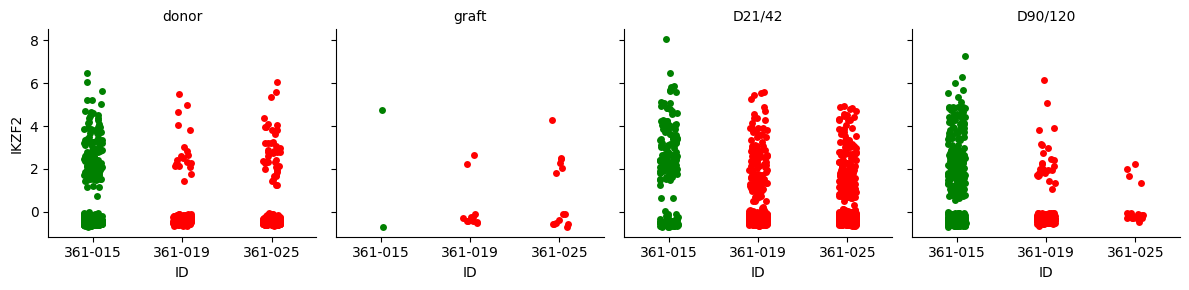

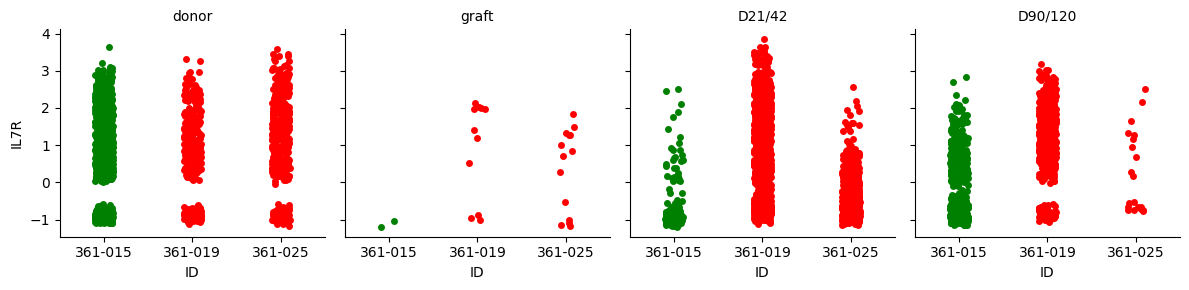

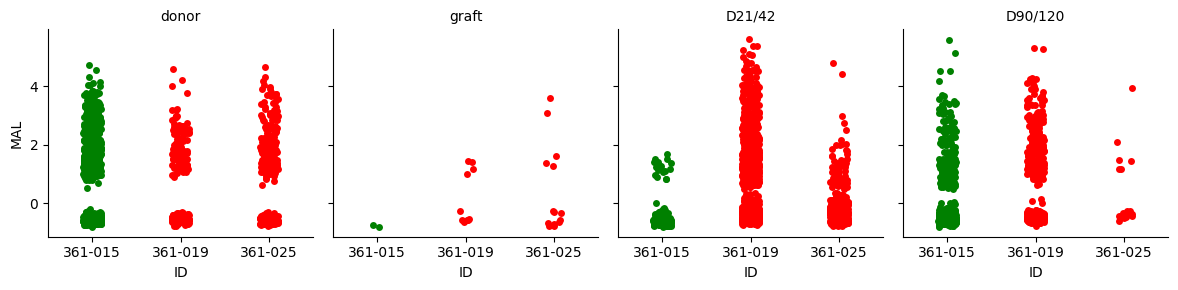

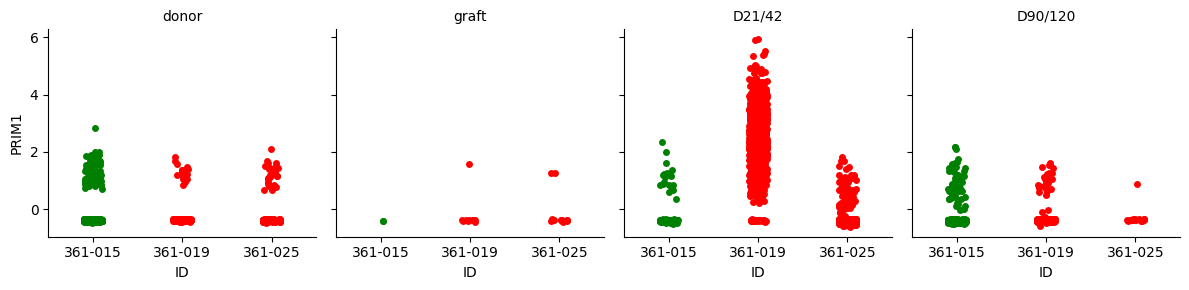

In [46]:
for gene in sig_genes:
    rows = rna_adata.obs["consensus_l2_celltype"] == "T cells"
    facet_cols = "day_label"
    col_order = ( 'donor', 'graft', 'D21/42', 'D90/120')
    x_tick_order =  ('361-015', '361-019', '361-025')
    x_vals = "ID"
    y_val = gene
    rna_sig_adata = rna_adata[rows, y_val]
    palette = {"no": "green", "yes": "red"}
    
    df = pd.DataFrame(
        rna_sig_adata.X,
        columns=rna_sig_adata.var_names,
        index=rna_sig_adata.obs_names
    )
    
    df[facet_cols] = rna_sig_adata.obs[facet_cols]
    df[x_vals] = rna_sig_adata.obs[x_vals]
    df["aGvHD"] = rna_sig_adata.obs["aghvd"]
    
    g = sns.FacetGrid(df, col=facet_cols, col_order=col_order, hue="aGvHD", palette=palette)
    g.map(sns.stripplot, x_vals, y_val, order=x_tick_order)
    g.set_xlabels(None)
    g.set_ylabels(y_val)
    g.set_titles(col_template="{col_name}")

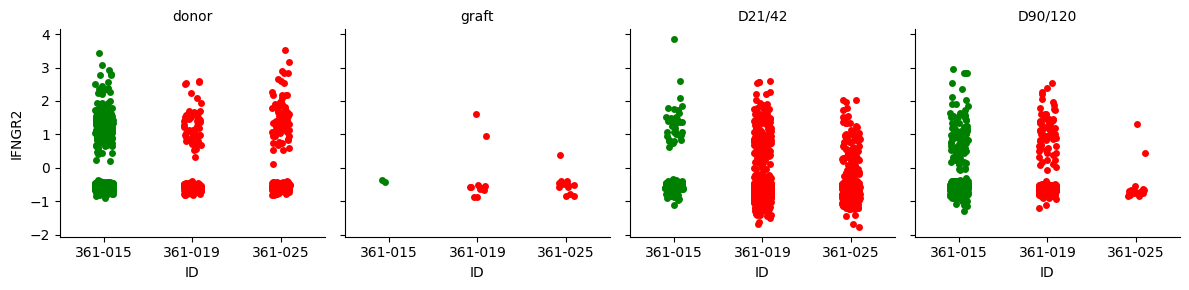

In [58]:
y_val = "IFNGR2"
rows = rna_adata.obs["consensus_l2_celltype"] == "T cells"
facet_cols = "day_label"
col_order = ( 'donor', 'graft', 'D21/42', 'D90/120')
x_tick_order =  ('361-015', '361-019', '361-025')
x_vals = "ID"

rna_sig_adata = rna_adata[rows, y_val]
palette = {"no": "green", "yes": "red"}

df = pd.DataFrame(
    rna_sig_adata.X,
    columns=rna_sig_adata.var_names,
    index=rna_sig_adata.obs_names
)

df[facet_cols] = rna_sig_adata.obs[facet_cols]
df[x_vals] = rna_sig_adata.obs[x_vals]
df["aGvHD"] = rna_sig_adata.obs["aghvd"]

g = sns.FacetGrid(df, col=facet_cols, col_order=col_order, hue="aGvHD", palette=palette)
g.map(sns.stripplot, x_vals, y_val, order=x_tick_order)
g.set_xlabels(None)
g.set_ylabels(y_val)
g.set_titles(col_template="{col_name}")

In [94]:
sig_col = rna_adata.var_names.isin(sig_genes)
path_dir = "../data/d21-d24_sig_genes.csv"
df = pd.DataFrame(rna_adata[:, sig_col].X, columns=rna_adata[:, sig_genes].var_names)
df["gvhd_lbl"] = list(rna_adata[:, sig_col].obs["gvhd_lbl"])
df.to_excel("../data/d21-d41_sig_genes.xlsx", index=False)